# GFP stats and ideal number of microstates

Analysis of number GFP peaks and ideal number of canonical microstates.

In [1]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

from src.helpers import PLOTS_ROOT, RESULTS_ROOT, make_dirs

plt.style.use("default")
plt.rcParams["legend.frameon"] = False
plt.rcParams["figure.figsize"] = (20, 9)
sns.set_context("notebook", font_scale=1.75)

WORKING_DIR = os.path.join(RESULTS_ROOT, "gfp_and_no_mstates")
PLOTTING_DIR = os.path.join(PLOTS_ROOT, "new")
make_dirs(PLOTTING_DIR)

# if True, will save all statistical tests as csv and all plots as eps
SAVE_RESULTS = True
PLOT_EXT = ".eps"
# which correction for multiple comparisons should be used
MULTI_CORRECTION = "fdr_by"

In [2]:
# load data computed with `1-main_gfp_stats_and_ideal_no_mstates.py`
df = pd.read_csv(
    os.path.join(WORKING_DIR, "gfp_peaks_var_test.csv"), index_col=[0]
)
df = df.drop_duplicates(subset=df.columns.difference(["filter"]))
# divide session into PLA/PSI and time for plotting purposes
df[["condition", "time"]] = df["session"].str.split("-", expand=True)
# df["filter"] = df["filter"].replace({1: "2.0-20.0", 2: "1.0-40.0"})
# # divide to filters
df_220 = df[df["filter"] == "2.0-20.0"]
df_140 = df[df["filter"] == "1.0-40.0"]

In [3]:
df_220

,subject,session,filter,# GFP peaks,method,# states,PM variance total,PM variance GFP,Davies-Bouldin,Dunn,Silhouette,Calinski-Harabasz,condition,time
0,1,PLA-T1,2.0-20.0,915,corr,2,0.545314,0.444442,51.426517,1.487469e-02,0.003955,3.201667,PLA,T1
1,1,PLA-T1,2.0-20.0,915,GMD,2,0.545312,0.444442,1.648178,1.973321e-02,0.191817,3368.173058,PLA,T1
0,1,PLA-T1,2.0-20.0,915,corr,3,0.543656,0.438925,49.760195,5.774720e-17,-0.008410,3.114521,PLA,T1
1,1,PLA-T1,2.0-20.0,915,GMD,3,0.543817,0.438943,2.622126,1.973321e-02,0.091616,1931.706617,PLA,T1
0,1,PLA-T1,2.0-20.0,915,corr,4,0.569794,0.460473,32.995901,5.461569e-17,-0.035315,8.590360,PLA,T1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,21,PSI-T5,2.0-20.0,861,GMD,8,0.384959,0.253666,3.204703,1.217154e-16,-0.014728,1357.010238,PSI,T5
0,21,PSI-T5,2.0-20.0,861,corr,9,0.444132,0.288718,31.668583,8.521589e-17,-0.113211,9.687678,PSI,T5
1,21,PSI-T5,2.0-20.0,861,GMD,9,0.445099,0.295394,3.531129,1.236155e-16,-0.036388,1207.549912,PSI,T5
0,21,PSI-T5,2.0-20.0,861,corr,10,0.526594,0.339382,41.572824,8.521589e-17,-0.104208,7.408404,PSI,T5


In [4]:
def _plot_ttest_signi(where, df_for_max, ax, x1_base=-0.2, x2_base=0.2):
    y = df_for_max.max() * 1.02
    h = df_for_max.max() * 0.05
    col = plt.rcParams["text.color"]
    for _, row in where.iterrows():
        pos = int(row["time"][-1]) - 1
        x1, x2 = x1_base + pos, x2_base + pos
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
        if row["p-corr"] < 0.001:
            text = "p < 0.000"
        else:
            text = f"p={row['p-corr']:.3f}"
        ax.text(
            (x1 + x2) * 0.5, y + h, text, ha="center", va="bottom", color=col
        )

## Number of GFP peaks

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/Users/nikola/.virtualenvs/eeg_latent/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


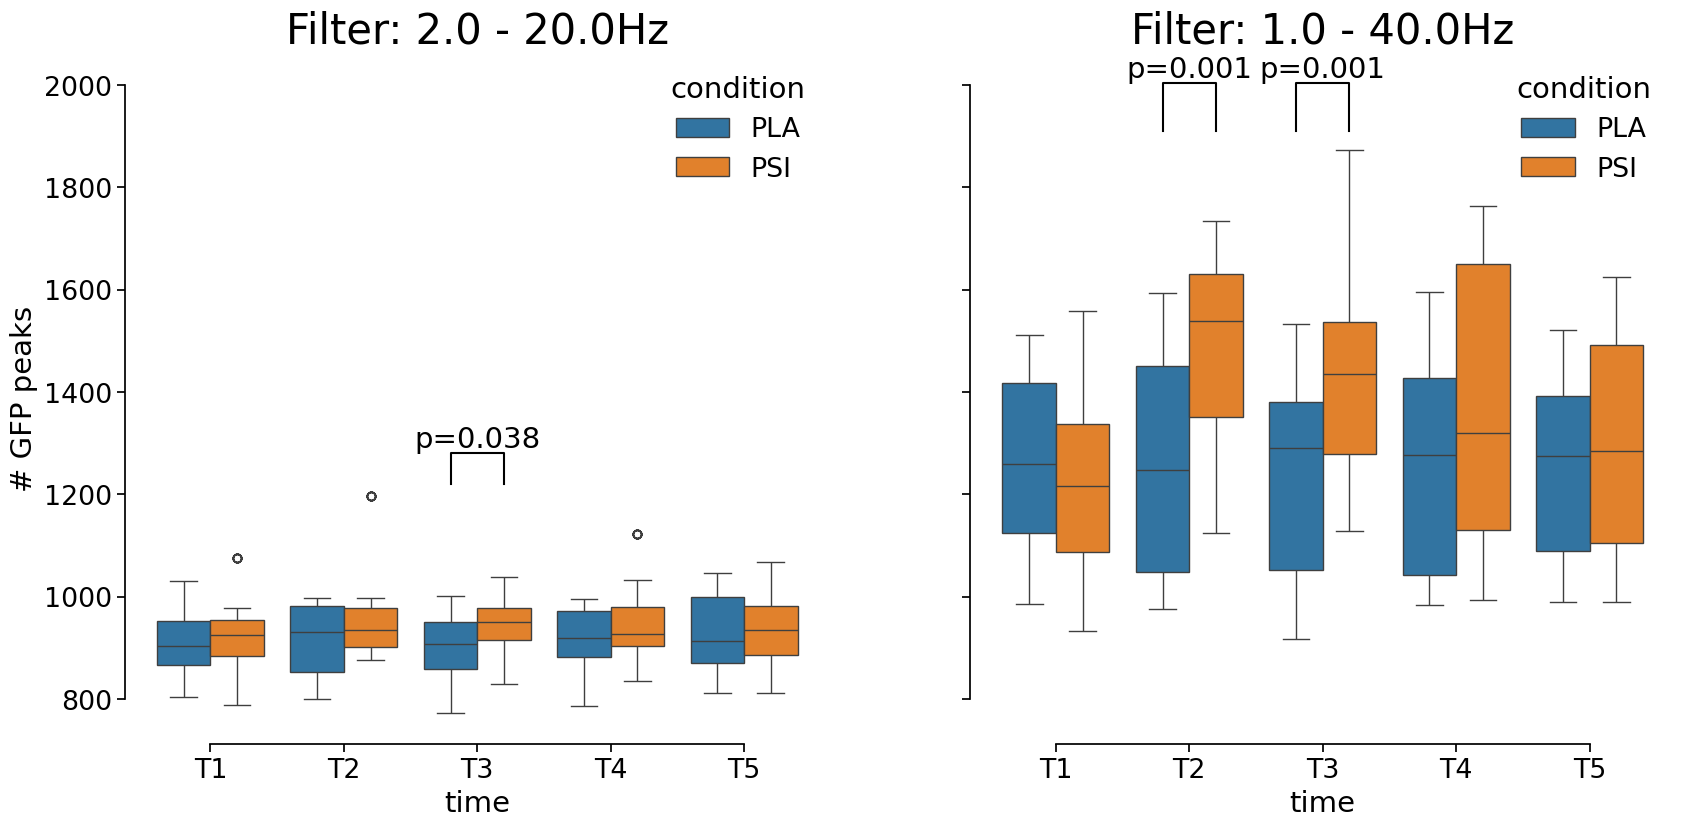

In [5]:
_, axs = plt.subplots(1, 2, sharey=True)
sns.boxplot(x="time", y="# GFP peaks", hue="condition", data=df_220, ax=axs[0])
axs[0].set_title("Filter: 2.0 - 20.0Hz", size=30)
sign = pg.pairwise_ttests(
    data=df_220,
    dv="# GFP peaks",
    within=["time", "condition"],
    subject="subject",
    padjust=MULTI_CORRECTION,
)
# find significant
where = sign[
    (sign["p-corr"] <= 0.05) & (sign["Contrast"] == "time * condition")
]
_plot_ttest_signi(
    where, df_220["# GFP peaks"], ax=axs[0], x1_base=-0.2, x2_base=0.2
)

bplot = sns.boxplot(
    x="time", y="# GFP peaks", hue="condition", data=df_140, ax=axs[1]
)
axs[1].set_title("Filter: 1.0 - 40.0Hz", size=30)
sign = pg.pairwise_ttests(
    data=df_140,
    dv="# GFP peaks",
    within=["time", "condition"],
    subject="subject",
    padjust=MULTI_CORRECTION,
)
# find significant
where = sign[
    (sign["p-corr"] <= 0.05) & (sign["Contrast"] == "time * condition")
]
_plot_ttest_signi(
    where, df_140["# GFP peaks"], ax=axs[1], x1_base=-0.2, x2_base=0.2
)
sns.despine(trim=True)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(PLOTTING_DIR, f"num_gfp_boxplot{PLOT_EXT}"),
        bbox_inches="tight",
        transparent=True,
    )

### ANOVA and posthoc for 2-20Hz filter

In [6]:
# norm = pg.normality(data=df_220, dv="# GFP peaks", group="session")
# if SAVE_RESULTS:
#     norm.round(5).to_csv(os.path.join(WORKING_DIR, "gfp_peaks_2-20filt_normality.csv"))
# norm

In [7]:
# # repeated measures ANOVA
# anova = pg.rm_anova(
#     data=df_220, dv="# GFP peaks", within=["time", "condition"], subject="subject"
# )
# if SAVE_RESULTS:
#     anova.round(5).to_csv(os.path.join(WORKING_DIR, "gfp_peaks_2-20filt_rm_anova.csv"))
# anova

In [8]:
# posthoc = pg.pairwise_ttests(
#     data=df_220,
#     dv="# GFP peaks",
#     within=["time", "condition"],
#     subject="subject",
#     alpha=0.05,
#     padjust=MULTI_CORRECTION,
#     return_desc=True,
# )
# if SAVE_RESULTS:
#     posthoc.round(5).to_csv(os.path.join(WORKING_DIR, "gfp_peaks_2-20filt_posthoc.csv"))
# posthoc

In [9]:
# for time in ["T1", "T2", "T3", "T4", "T5"]:
#     pg.plot_shift(
#         df_220[df_220["session"] == f"PLA-{time}"]["# GFP peaks"],
#         df_220[df_220["session"] == f"PSI-{time}"]["# GFP peaks"],
#         paired=True,
#     )
#     plt.suptitle(f"Filter: (2.0, 20.0); time {time}")
#     if SAVE_RESULTS:
#         plt.savefig(
#             os.path.join(PLOTTING_DIR, f"num_gfp_shiftplot_2-20filt_{time}{PLOT_EXT}"),
#             bbox_inches="tight",
#             transparent=True,
#         )

### ANOVA and posthoc for 1-40Hz filter

In [10]:
# norm = pg.normality(data=df_140, dv="# GFP peaks", group="session")
# if SAVE_RESULTS:
#     norm.round(5).to_csv(os.path.join(WORKING_DIR, "gfp_peaks_1-40filt_normality.csv"))
# norm

In [11]:
# # repeated measures ANOVA
# anova = pg.rm_anova(
#     data=df_140,
#     dv="# GFP peaks",
#     within=["time", "condition"],
#     subject="subject",
# )
# if SAVE_RESULTS:
#     anova.round(5).to_csv(os.path.join(WORKING_DIR, "gfp_peaks_1-40filt_rm_anova.csv"))
# anova

In [12]:
# posthoc = pg.pairwise_ttests(
#     data=df_140,
#     dv="# GFP peaks",
#     within=["time", "condition"],
#     subject="subject",
#     alpha=0.05,
#     padjust=MULTI_CORRECTION,
#     return_desc=True,
# )
# if SAVE_RESULTS:
#     posthoc.round(5).to_csv(os.path.join(WORKING_DIR, "gfp_peaks_1-40filt_posthoc.csv"))
# posthoc

In [13]:
# for time in ["T1", "T2", "T3", "T4", "T5"]:
#     pg.plot_shift(
#         df_140[df_140["session"] == f"PLA-{time}"]["# GFP peaks"],
#         df_140[df_140["session"] == f"PSI-{time}"]["# GFP peaks"],
#         paired=True,
#     )
#     plt.suptitle(f"Filter: (1.0, 40.0); time {time}")
#     if SAVE_RESULTS:
#         plt.savefig(
#             os.path.join(PLOTTING_DIR, f"num_gfp_shiftplot_1-40filt_{time}{PLOT_EXT}"),
#             bbox_inches="tight",
#             transparent=True,
#         )

## Ideal number of canonical microstates

### 2-20Hz filter

In [14]:
df_220_ns = df_220.set_index(
    ["method", "condition", "time", "subject", "# states"]
).sort_index()

In [15]:
no_states = df_220_ns.index.unique(level=-1).values
ideal_ms220 = pd.DataFrame(columns=["method", "session", "ideal #", "measure"])
filter_str = df_220_ns["filter"].unique()[0]

functions = {
    "PM variance total": (lambda x: x.min(axis=1), lambda x: x.argmin(axis=1)),
    "PM variance GFP": (lambda x: x.min(axis=1), lambda x: x.argmin(axis=1)),
    "Davies-Bouldin": (lambda x: x.min(axis=1), lambda x: x.argmin(axis=1)),
    "Dunn": (lambda x: x.max(axis=1), lambda x: x.argmax(axis=1)),
    "Silhouette": (lambda x: x.max(axis=1), lambda x: x.argmax(axis=1)),
    "Calinski-Harabasz": (lambda x: x.max(axis=1), lambda x: x.argmax(axis=1)),
}

for measure in df_220_ns.columns[3:]:
    # _, axs = plt.subplots(
    #     nrows=len(df_220_ns.index.unique(level=2)),
    #     ncols=len(df_220_ns.index.unique(level=1)),
    #     sharex=True,
    #     sharey=True,
    #     figsize=(15, 15),
    # )
    for i, (session, df_) in enumerate(df_220_ns.groupby(level=[1, 2])):
        df_plot = df_[measure].reset_index()
        values_corr = (
            df_plot[df_plot["method"] == "corr"].pivot(
                index="subject", columns="# states", values=measure
            )
        ).values  # subjects x states
        values_gmd = (
            df_plot[df_plot["method"] == "GMD"].pivot(
                index="subject", columns="# states", values=measure
            )
        ).values  # subjects x states
        ideal_num_corr = no_states[functions[measure][1](values_corr)]
        ideal_num_gmd = no_states[functions[measure][1](values_gmd)]
        # jj = 0 if session[0] == "PLA" else 1
        # ii = int(session[1][1:]) - 1
        # ax = axs[ii, jj]
        # ax.plot(no_states, values_corr.T, color="C0", linewidth=0.5)
        # ax.plot(no_states, values_gmd.T, color="C1", linewidth=0.5)
        # ax.plot(ideal_num_corr, functions[measure][0](values_corr), "o", color="indianred")
        # ax.plot(ideal_num_gmd, functions[measure][0](values_gmd), "o", color="limegreen")
        # ax.plot(no_states, values_corr.mean(axis=0), color="C2")
        # ax.plot(no_states, values_gmd.mean(axis=0), color="C3")
        # ax.set_title(
        #     f"{'-'.join(session)} ~ {np.median(ideal_num_corr)} / {np.median(ideal_num_gmd)}"
        # )
        ideal_ms220 = pd.concat(
            [
                ideal_ms220,
                pd.DataFrame(
                    {
                        "method": "corr",
                        "session": "-".join(session),
                        "ideal #": np.median(ideal_num_corr),
                        "measure": measure,
                    },
                    index=[0],
                ),
                pd.DataFrame(
                    {
                        "method": "GMD",
                        "session": "-".join(session),
                        "ideal #": np.median(ideal_num_gmd),
                        "measure": measure,
                    },
                    index=[1],
                ),
            ]
        )
    # plt.suptitle(f"{measure} // filter: {filter_str}Hz")

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_62742/432884630.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ideal_ms220 = pd.concat(


In [16]:
ideal_ms220[["condition", "time"]] = ideal_ms220["session"].str.split(
    "-", expand=True
)
ideal_ms220

,method,session,ideal #,measure,condition,time
0,corr,PLA-T1,3.0,PM variance total,PLA,T1
1,GMD,PLA-T1,3.0,PM variance total,PLA,T1
0,corr,PLA-T2,3.0,PM variance total,PLA,T2
1,GMD,PLA-T2,3.0,PM variance total,PLA,T2
0,corr,PLA-T3,3.0,PM variance total,PLA,T3
...,...,...,...,...,...,...
1,GMD,PSI-T3,2.0,Calinski-Harabasz,PSI,T3
0,corr,PSI-T4,6.0,Calinski-Harabasz,PSI,T4
1,GMD,PSI-T4,3.0,Calinski-Harabasz,PSI,T4
0,corr,PSI-T5,5.0,Calinski-Harabasz,PSI,T5


In [17]:
# sns.scatterplot(
#     x="measure",
#     y="session",
#     hue="ideal #",
#     data=ideal_ms,
#     size="ideal #",
#     legend="full",
#     palette="viridis",
# )
# plt.title(f"filter: {filter_str}Hz")

In [18]:
df_140_ns = df_140.set_index(
    ["method", "condition", "time", "subject", "# states"]
).sort_index()

In [19]:
no_states = df_140_ns.index.unique(level=-1).values
ideal_ms140 = pd.DataFrame(columns=["method", "session", "ideal #", "measure"])
filter_str = df_140_ns["filter"].unique()[0]

functions = {
    "PM variance total": (lambda x: x.min(axis=1), lambda x: x.argmin(axis=1)),
    "PM variance GFP": (lambda x: x.min(axis=1), lambda x: x.argmin(axis=1)),
    "Davies-Bouldin": (lambda x: x.min(axis=1), lambda x: x.argmin(axis=1)),
    "Dunn": (lambda x: x.max(axis=1), lambda x: x.argmax(axis=1)),
    "Silhouette": (lambda x: x.max(axis=1), lambda x: x.argmax(axis=1)),
    "Calinski-Harabasz": (lambda x: x.max(axis=1), lambda x: x.argmax(axis=1)),
}

for measure in df_140_ns.columns[3:]:
    # _, axs = plt.subplots(
    #     nrows=len(df_140_ns.index.unique(level=2)),
    #     ncols=len(df_140_ns.index.unique(level=1)),
    #     sharex=True,
    #     sharey=True,
    #     figsize=(15, 15),
    # )
    for i, (session, df_) in enumerate(df_140_ns.groupby(level=[1, 2])):
        df_plot = df_[measure].reset_index()
        values_corr = (
            df_plot[df_plot["method"] == "corr"].pivot(
                index="subject", columns="# states", values=measure
            )
        ).values  # subjects x states
        values_gmd = (
            df_plot[df_plot["method"] == "GMD"].pivot(
                index="subject", columns="# states", values=measure
            )
        ).values  # subjects x states
        ideal_num_corr = no_states[functions[measure][1](values_corr)]
        ideal_num_gmd = no_states[functions[measure][1](values_gmd)]
        # jj = 0 if session[0] == "PLA" else 1
        # ii = int(session[1][1:]) - 1
        # ax = axs[ii, jj]
        # ax.plot(no_states, values_corr.T, color="C0", linewidth=0.5)
        # ax.plot(no_states, values_gmd.T, color="C1", linewidth=0.5)
        # ax.plot(ideal_num_corr, functions[measure][0](values_corr), "o", color="indianred")
        # ax.plot(ideal_num_gmd, functions[measure][0](values_gmd), "o", color="limegreen")
        # ax.plot(no_states, values_corr.mean(axis=0), color="C2")
        # ax.plot(no_states, values_gmd.mean(axis=0), color="C3")
        # ax.set_title(
        #     f"{'-'.join(session)} ~ {np.median(ideal_num_corr)} / {np.median(ideal_num_gmd)}"
        # )
        ideal_ms140 = pd.concat(
            [
                ideal_ms140,
                pd.DataFrame(
                    {
                        "method": "corr",
                        "session": "-".join(session),
                        "ideal #": np.median(ideal_num_corr),
                        "measure": measure,
                    },
                    index=[0],
                ),
                pd.DataFrame(
                    {
                        "method": "GMD",
                        "session": "-".join(session),
                        "ideal #": np.median(ideal_num_gmd),
                        "measure": measure,
                    },
                    index=[1],
                ),
            ]
        )
    # plt.suptitle(f"{measure} // filter: {filter_str}Hz")

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_62742/445608894.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ideal_ms140 = pd.concat(


In [20]:
ideal_ms140[["condition", "time"]] = ideal_ms140["session"].str.split(
    "-", expand=True
)
ideal_ms140

,method,session,ideal #,measure,condition,time
0,corr,PLA-T1,3.0,PM variance total,PLA,T1
1,GMD,PLA-T1,3.0,PM variance total,PLA,T1
0,corr,PLA-T2,3.0,PM variance total,PLA,T2
1,GMD,PLA-T2,3.0,PM variance total,PLA,T2
0,corr,PLA-T3,3.0,PM variance total,PLA,T3
...,...,...,...,...,...,...
1,GMD,PSI-T3,2.0,Calinski-Harabasz,PSI,T3
0,corr,PSI-T4,4.0,Calinski-Harabasz,PSI,T4
1,GMD,PSI-T4,2.0,Calinski-Harabasz,PSI,T4
0,corr,PSI-T5,5.0,Calinski-Harabasz,PSI,T5


In [21]:
# sns.scatterplot(
#     x="measure",
#     y="session",
#     hue="ideal #",
#     data=ideal_ms,
#     size="ideal #",
#     legend="full",
#     palette="viridis",
# )
# plt.title(f"filter: {filter_str}Hz")

### Summary plot for ideal number of microstates

In [22]:
# all_mins = pd.DataFrame()
# for i, df_ in df_220_ns.groupby(level=[0, 1, 2]):
#     mins = df_[df_220_ns.columns[3:]].idxmin().to_frame()
#     mins[["condition", "time", "subject", "# states"]] = mins[0].to_list()
#     mins = mins.drop(0, axis=1)
#     all_mins = pd.concat([all_mins, mins])
# all_mins = all_mins.reset_index().rename(columns={"index": "measure"})

# g = sns.displot(
#     all_mins,
#     x="# states",
#     col="time",
#     row="measure",
#     hue="condition",
#     multiple="dodge",
#     shrink=0.8,
#     facet_kws=dict(margin_titles=True),
#     height=5,
# )
# g.fig.suptitle("Filter: 2-20Hz", size=30)
# g.fig.subplots_adjust(top=.95)

In [23]:
# all_mins = pd.DataFrame()
# for i, df_ in df_140_ns.groupby(level=[0, 1, 2]):
#     mins = df_[df_140_ns.columns[3:]].idxmin().to_frame()
#     mins[["condition", "time", "subject", "# states"]] = mins[0].to_list()
#     mins = mins.drop(0, axis=1)
#     all_mins = pd.concat([all_mins, mins])
# all_mins = all_mins.reset_index().rename(columns={"index": "measure"})

# g = sns.displot(
#     all_mins,
#     x="# states",
#     col="time",
#     row="measure",
#     hue="condition",
#     multiple="dodge",
#     shrink=0.8,
#     facet_kws=dict(margin_titles=True),
#     height=5,
# )
# g.fig.suptitle("Filter: 1-40Hz", size=30)
# g.fig.subplots_adjust(top=.95)

In [24]:
ideal_ms140["filter"] = "Filter: 1.0 - 40.0Hz"
ideal_ms220["filter"] = "Filter: 2.0 - 20.0Hz"
ideal_ms = pd.concat([ideal_ms220, ideal_ms140])
ideal_ms = ideal_ms[ideal_ms["measure"] == "PM variance total"]
ideal_ms

,method,session,ideal #,measure,condition,time,filter
0,corr,PLA-T1,3.0,PM variance total,PLA,T1,Filter: 2.0 - 20.0Hz
1,GMD,PLA-T1,3.0,PM variance total,PLA,T1,Filter: 2.0 - 20.0Hz
0,corr,PLA-T2,3.0,PM variance total,PLA,T2,Filter: 2.0 - 20.0Hz
1,GMD,PLA-T2,3.0,PM variance total,PLA,T2,Filter: 2.0 - 20.0Hz
0,corr,PLA-T3,3.0,PM variance total,PLA,T3,Filter: 2.0 - 20.0Hz
1,GMD,PLA-T3,3.0,PM variance total,PLA,T3,Filter: 2.0 - 20.0Hz
0,corr,PLA-T4,3.0,PM variance total,PLA,T4,Filter: 2.0 - 20.0Hz
1,GMD,PLA-T4,3.0,PM variance total,PLA,T4,Filter: 2.0 - 20.0Hz
0,corr,PLA-T5,3.0,PM variance total,PLA,T5,Filter: 2.0 - 20.0Hz
1,GMD,PLA-T5,3.0,PM variance total,PLA,T5,Filter: 2.0 - 20.0Hz


In [25]:
def get_min(grp):
    return grp.set_index("# states")["PM variance total"].idxmin()


ideal_220 = (
    df_220.groupby(["subject", "condition", "time", "method"])
    .apply(get_min)
    .reset_index()
    .rename(columns={0: "ideal #"})
)
ideal_220["filter"] = "Filter: 2.0 - 20.0Hz"
ideal_140 = (
    df_140.groupby(["subject", "condition", "time", "method"])
    .apply(get_min)
    .reset_index()
    .rename(columns={0: "ideal #"})
)
ideal_140["filter"] = "Filter: 1.0 - 40.0Hz"
ideal = pd.concat([ideal_220, ideal_140])
ideal["ideal #"] = ideal["ideal #"].astype(int)

# for idx, grp in df_220.groupby(["subject", "condition", "time", "method"]):
#     print(idx)
#     print(grp.set_index("# states")["PM variance total"].idxmin())
#     print()

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_62742/2298776990.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_220.groupby(["subject", "condition", "time", "method"])
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_62742/2298776990.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_140.groupby(["subject", "condition", "time", "method"])


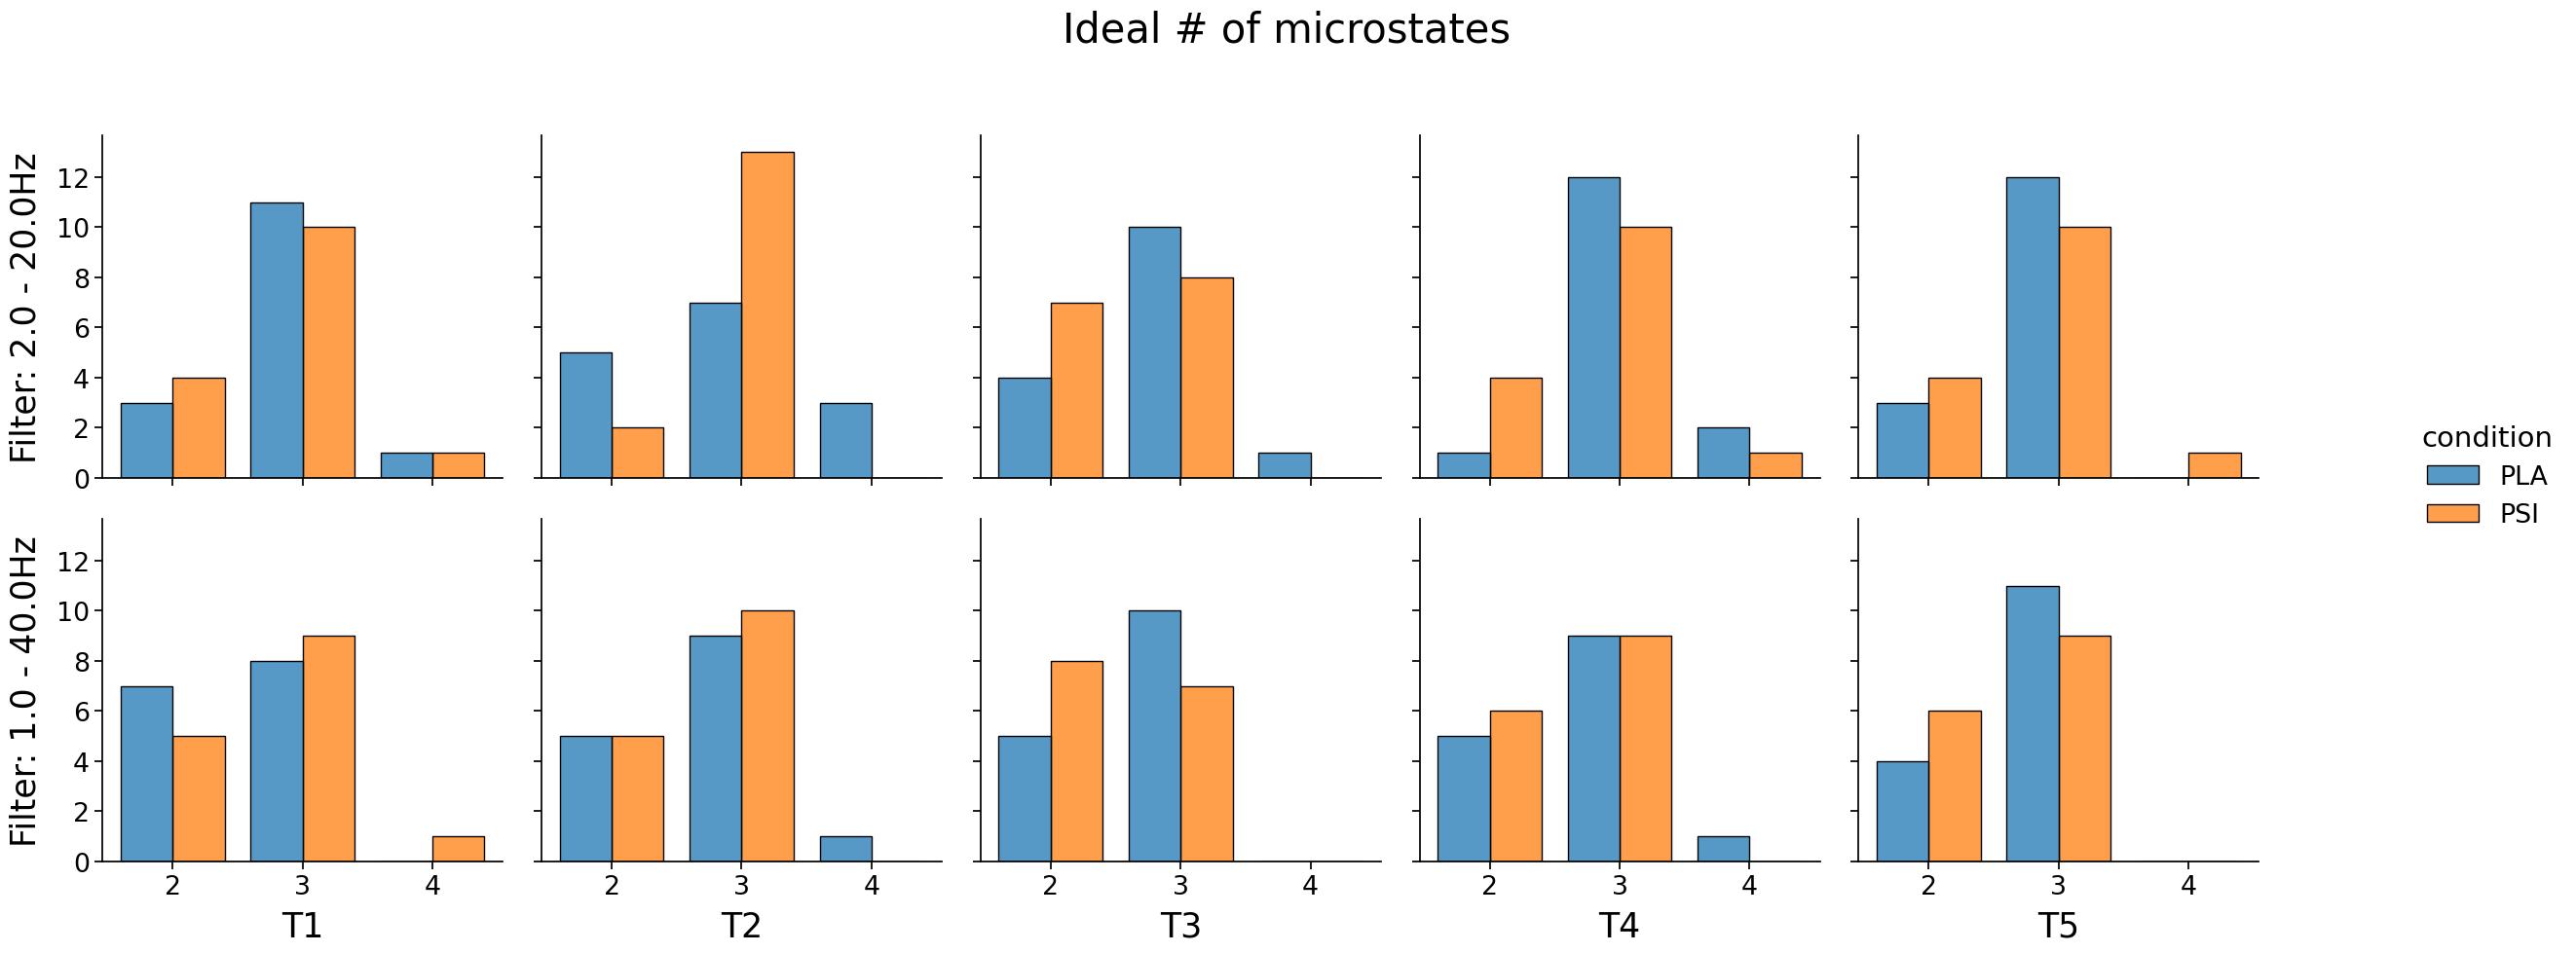

In [26]:
g = sns.displot(
    ideal[ideal["method"] == "corr"],
    x="ideal #",
    col="time",
    row="filter",
    hue="condition",
    multiple="dodge",
    discrete=True,
    shrink=0.8,
    facet_kws=dict(margin_titles=True),
    height=5,
)
g.set_titles(col_template="", row_template="")
g.figure.suptitle("Ideal # of microstates", size=30)
g.figure.subplots_adjust(top=0.85)

custom_yticks = [0, 2, 4, 6, 8, 10, 12]

for ax in g.axes.flat:
    ax.set_yticks(custom_yticks)

for ax in g.axes.flat:
    ax.set_xlabel("")
    ax.set_ylabel("")

for i, ax in enumerate(g.axes[-1, :]):
    # Get the position of this subplot
    bbox = ax.get_position()
    x_center = bbox.x0 + bbox.width / 2
    y_bottom = bbox.y0 - 0.05  # Adjust vertical position as needed

    # Add text label
    g.figure.text(
        x_center, y_bottom, g.col_names[i], ha="center", va="top", fontsize=25
    )

for i, ax in enumerate(g.axes[:, 0]):
    ax.set_ylabel(g.row_names[i], fontsize=25, rotation=90, labelpad=10)

if SAVE_RESULTS:
    plt.savefig(
        os.path.join(PLOTTING_DIR, f"ideal_num_ms_summary{PLOT_EXT}"),
        bbox_inches="tight",
        transparent=True,
    )
# plt.tight_layout()
# plt.subplots_adjust(bottom=0.08)

# plt.show()